## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

/Users/petermilner/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load Dataset

In [2]:
data = pd.read_csv('../data/processed/matches-2018-11-18T19:33:05.278801.csv', delimiter=',')

## Visualize Data

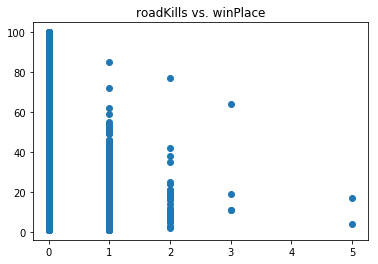

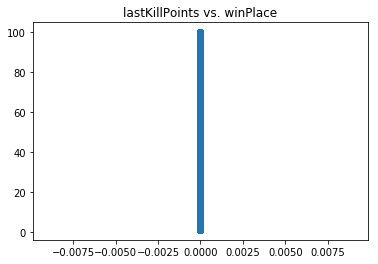

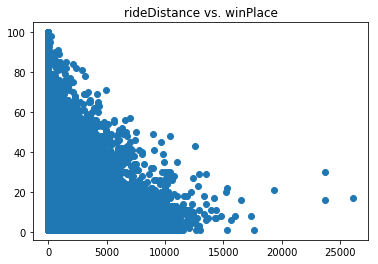

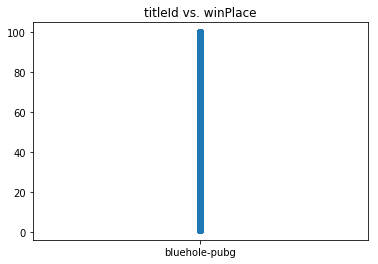

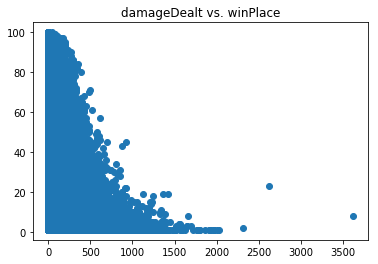

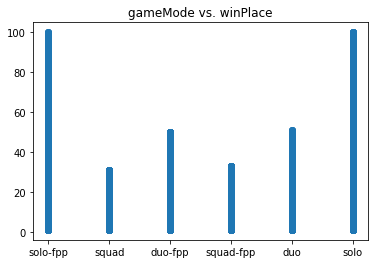

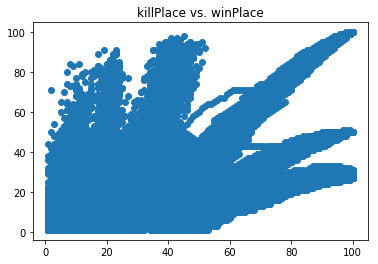

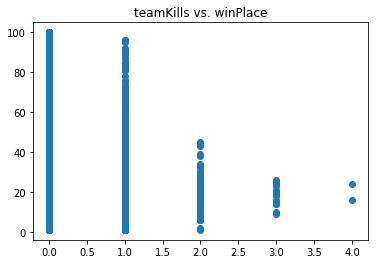

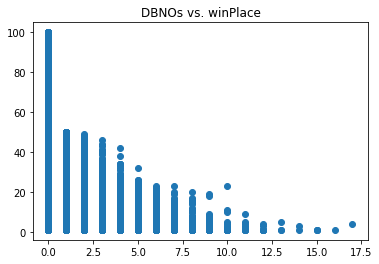

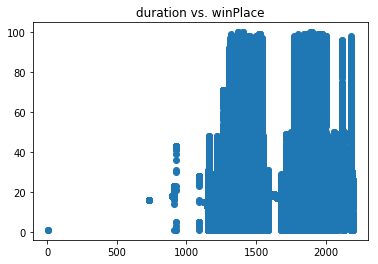

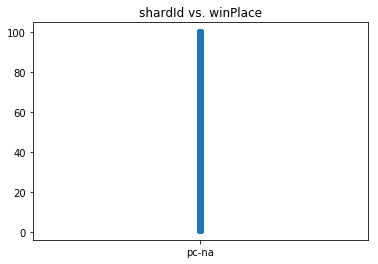

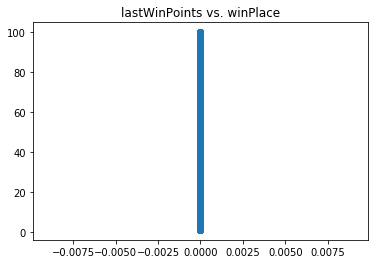

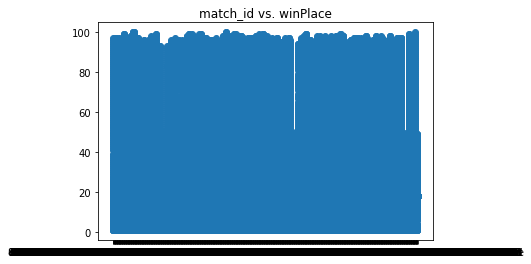

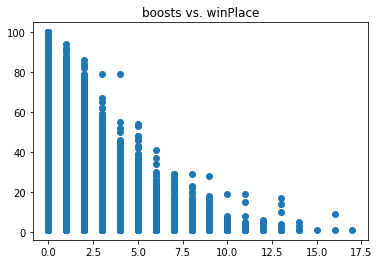

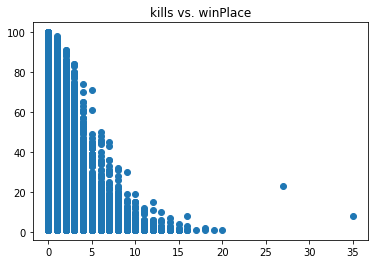

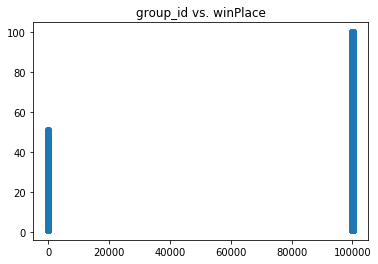

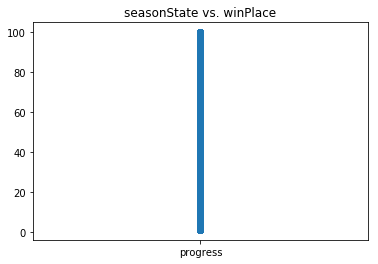

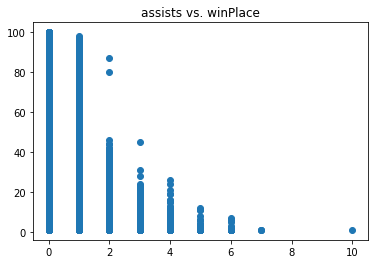

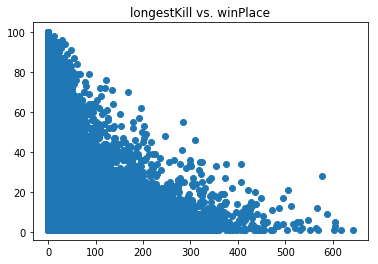

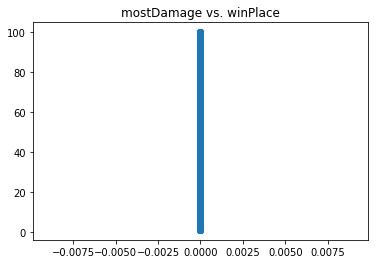

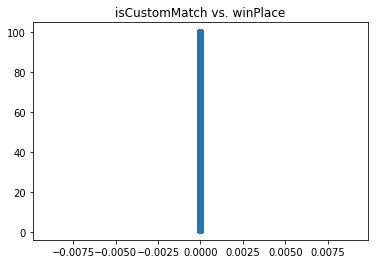

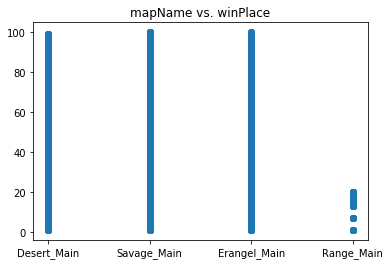

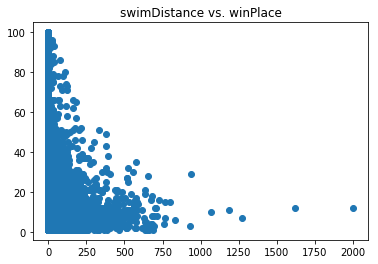

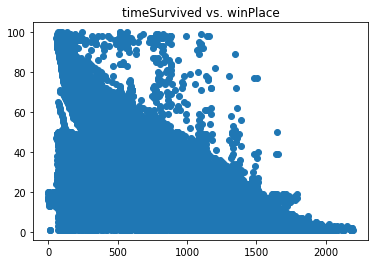

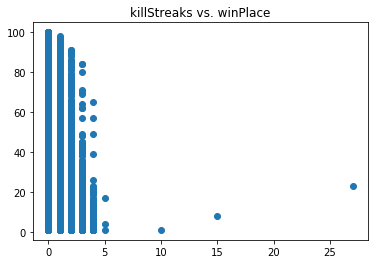

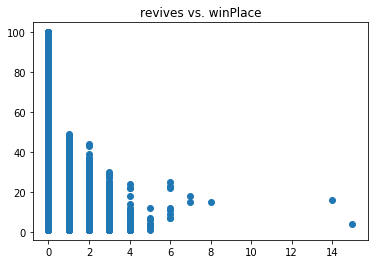

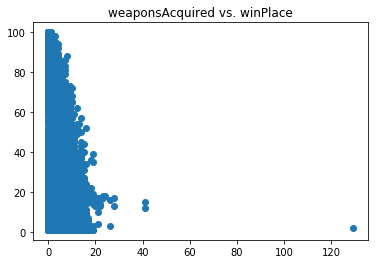

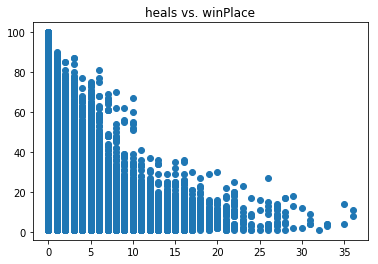

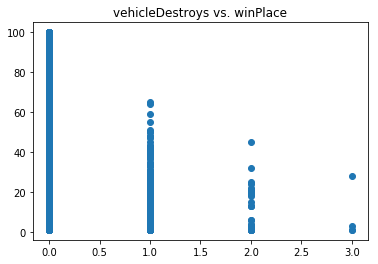

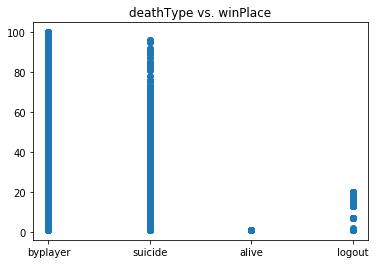

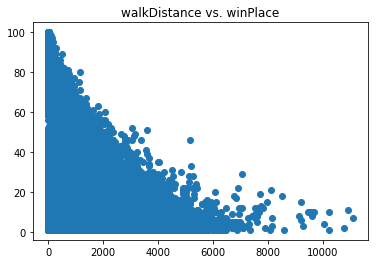

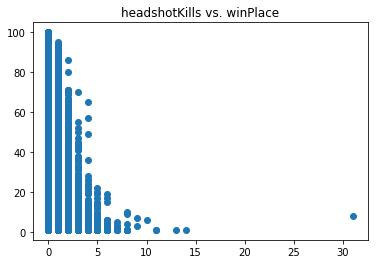

In [3]:
# Deprecated columns or not needed
useless_columns = ['id', 'killPoints', 'killPointsDelta', 'rankPoints', 'winPoints', 'winPointsDelta', 'stats', 'tags', 'createdAt', 'name', 'playerId']
# Value that we are predicting
y_column = 'winPlace'

columns = list(set(data.columns) - set(useless_columns) - set([y_column]))

for col in columns:
    fig = plt.figure()
    plt.title("{} vs. {}".format(col, y_column))
    plt.scatter(data[col], data[y_column])
    plt.savefig("figures/{}vs{}".format(col, y_column))
    plt.show(block=False)
    plt.close(fig)
    

## Visualize killPlace and duration with Categorical Labels

In [ ]:
categorical_columns = ['deathType', 'mapName', 'gameMode']

interesting_columns = ['killPlace', 'duration']

for labelColumn in categorical_columns:
    for col in interesting_columns:
        fig = plt.figure()

        labels = list(set(data[labelColumn]))
        for label in labels:
            d = data.query('{} == "{}"'.format(labelColumn, label))
            plt.title("{} vs. {} by {}".format(col, y_column, labelColumn))
            plt.scatter(d[col], d[y_column], label=label)

        plt.legend()
        plt.savefig("{}vs.{}by{}".format(col, y_column, labelColumn))
        plt.show(block=False)
        plt.close(fig)

In [4]:
# Remove more columns based on lack of correlation shown in above charts
useless_columns += ['lastWinPoints', 'lastKillPoints', 'titleId', 'shardId', 'seasonState', 'isCustomMatch', 'mostDamage']

## Split Sets

In [5]:
data = data.drop(columns=useless_columns)

# Grab 80% of data for training at random
train = data.sample(frac=0.8)
test = data.drop(train.index)

train_Y = train[y_column]
train_X = train.drop(columns=[y_column])

test_Y = test[y_column]
test_X = test.drop(columns=[y_column])

## Pre-processing

In [6]:
# Create subsets of columns

ordinal_columns = ['groupId', 'matchId']
# Ordinal columns are different from other_columns because they need to be encoded
other_columns = list(set(train_X.columns.values) - set(categorical_columns) - set(ordinal_columns))

In [7]:
# Vectorize categorical columns

for c in categorical_columns:
    le = LabelEncoder()
    train_X[c] = le.fit_transform(train_X[c])
    ohe = OneHotEncoder(sparse = False)
    train_X = train_X.join(pd.DataFrame(list(ohe.fit_transform(train_X.pop(c).values.reshape(-1, 1))), columns = ['{}-{}'.format(c, i) for i in ohe.active_features_], index = train_X.index))
    test_X[c] = le.transform(test_X[c])
    test_X = test_X.join(pd.DataFrame(list(ohe.transform(test_X.pop(c).values.reshape(-1, 1))), columns = ['{}-{}'.format(c, i) for i in ohe.active_features_], index = test_X.index))



In [8]:
# Encode ids

for c in ordinal_columns:
    le = LabelEncoder()
    train_X[c] = le.fit_transform(train_X[c])
    test_X[c] = le.transform(test_X[c])

In [9]:
# Scale

for c in other_columns:
    s = MinMaxScaler()
    train_X[c] = s.fit_transform(train_X[c].values.reshape(-1, 1))
    test_X[c] = s.transform(test_X[c].values.reshape(-1, 1))

/Users/petermilner/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Linear Regression

In [10]:
train_X.shape

(75444, 37)

In [11]:
lr = LinearRegression()
lr.fit(X=train_X, y=train_Y)

pred = lr.predict(test_X)

print('Error: {}'.format(mean_squared_error(test_Y, pred)))

Error: 67.04831712612686


## Decision Tree Regressor

In [12]:
dtr = tree.DecisionTreeRegressor()
dtr.fit(X=train_X, y=train_Y)

pred = dtr.predict(test_X)

print('Error: {}'.format(mean_squared_error(test_Y, pred)))

Error: 12.444780234346005


## Random Forest Regressor

In [13]:
rfr = RandomForestRegressor()
rfr.fit(X=train_X, y=train_Y)

pred = rfr.predict(test_X)

print('Error: {}'.format(mean_squared_error(test_Y, pred)))

Error: 7.009758231270876


## AdaBoost Regressor

In [14]:
abr = AdaBoostRegressor()
abr.fit(X=train_X, y=train_Y)

pred = abr.predict(test_X)

print('Error: {}'.format(mean_squared_error(test_Y, pred)))

Error: 47.6419761034636


## GradientBoosting Regressor

In [15]:
gbr = GradientBoostingRegressor()
gbr.fit(X=train_X, y=train_Y)

pred = gbr.predict(test_X)

print('Error: {}'.format(mean_squared_error(test_Y, pred)))

Error: 12.767813995567465
